[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/basic_submission.ipynb)

# 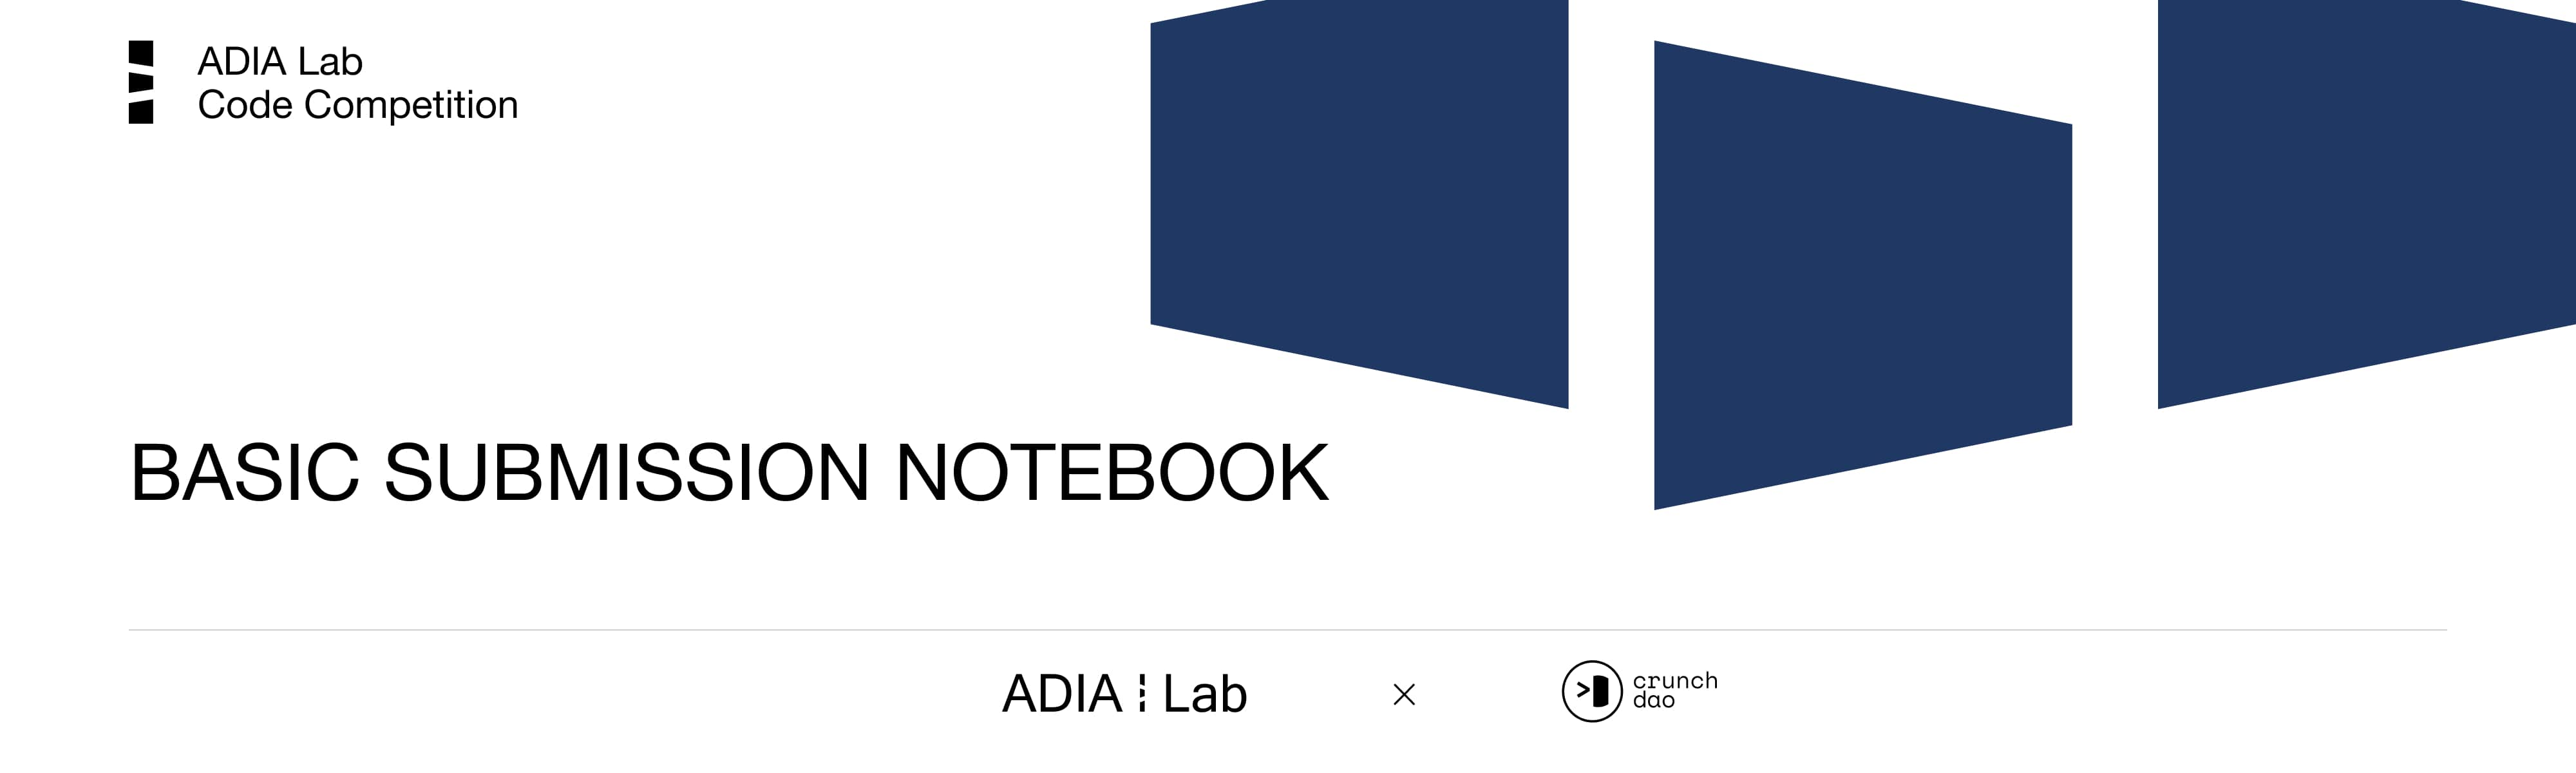

# Set up your crunch workspace

#### STEP 1
Run this cell to install the crunch library in your workspace.

In [1]:
!pip3 install crunch-cli --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
  Created wheel for gitignorefile: filename=gitignorefile-1.1.2-py3-none-any.whl size=6672 sha256=26ed40b1169c1e340c91f261bd9c6b9e47791ea51a9ac8e16e35b475b5da3019
  Stored in directory: /root/.cache/pip/wheels/6d/dc/c7/5875272151d55a37a44c163d1bddb1cdfff35278b82dcf4ba7
Successfully built gitignorefile


#### STEP 2
Import the crunch package and instantiate it to be able to access its functionality.

In [3]:
import crunch
crunch = crunch.load_notebook(__name__)

loaded inline runner with module: <module '__main__'>


#### STEP 3

In [4]:
# go to your submit page and copy paste your setup command to access the data
# https://adialab.crunchdao.com/submit
!crunch --notebook setup happy-mike --token 7BWS4CJWQUvflZZf3zV7NBvYNl4U3YSdrohLTCcYPRkF3S9JGH3YG5LXmBSZCPeX
%cd happy-mike

extract happy-mike/main.py
extract happy-mike/notebook.ipynb
extract happy-mike/requirements.txt
download data/X_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_train.parquet
download data/y_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/y_train.parquet
download data/X_test.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_test_reduced.parquet
                                         
---
Success! Your environment has been correctly setup.
Next recommended actions:
 - To get inside your workspace directory, run: cd happy-mike
 - To see all of the available commands of the CrunchDAO CLI, run: crunch --help
/content/happy-mike


# ADIA Lab Market Prediction

## A code competition

This competition is divided in two phases.

Submission phase - 12 weeks

Out-of-Sample phase - 12 weeks

During the first phase, participants will submit Python notebooks or Python scripts which build their best possible model on the data proposed by the organizers. In the second phase, also called [Out-of-Sample](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (OOS) phase, the participant's code will be automatically executed by the platform on unseen data. During this phase, the participants won't be able to modify their code.

There are two main reasons for this:

- Participants won't be able to game or cheat their scores.

- [Overfitting](https://deliverypdf.ssrn.com/delivery.php?ID=634087103098022017102089127026118070055022030067038035066070070118003108076075122073107013020035005031116084117030102014013119017036066065011126115081078006004108029033051020066006092025091103065117104075029100098011096065096065079019015002101078070&EXT=pdf&INDEX=TRUE) of the training data will lead to very bad performance OOS.

To ensure reproducibility of your work, you will need to follow certain coding guidelines to participate in the competition. These guidelines will also allow our scoring system to run your code in the cloud during the OOS period without any issues.

In this competition, CrunchDAO acts as a third party intermediary and will never communicate this code to the organizers.

## The Coding Guideline

Your submission needs at least to provide three components: imports, `train()`, and `infer()`.

1. **imports**: As with any script, if your solution contains dependencies on external packages make sure to import them. The system will automatically install your dependancies. Make sure that you are using only packages that are whitelisted [here](https://adialab.crunchdao.io/submit?tab=libraries).

2. **`train()`**: In the training phase the users will build the model and train it such that it can perform inferences on the testing data. The model must be saved in the `resources` directory.

4. **`infer()`**: In the inference function the model trained in the previous step will be loaded and used to perform inferences on a data sample matching the characteristic of the training test.

## Scoring on the public leaderboard

To ensure the reliability of the public leaderboard, you don't have access to all of the testing data on which you will be scored.
The `X_test` data downloaded in your workspace is composed of **only** 5 dates to test locally that your code actually runs when submitted. Notice that `y_test` is not available for those 5 dates.
Once you have uploaded your solution the system will run your code on a larger test set of approximately 30 dates, and compute the score.

When submitting, you are left to decide how frequently to retrain your model, considering the limit of 5 hours of resources / week / user allowed to predict the 30 dates of the private test set.


## Scoring on the out-of-sample phase

During the out-of-sample phase, after the submission period ends, the system will call your code 3 times every week on live datapoint.

The mean spearman score after 12 weeks of OOS will determine the winners of the tournament.


# Construction of a basic submission

### Submission process

1- Make sure to put all your code in the code interface inside your Notebook. The system will parse these functions to execute it in the cloud. You can work outside of the code interface but to be able to submit you will need to fill in the submission function with the code you want to submit

2- Once satisfied with your work. Download this notebook ( file -> Download -> Download.ipynb )

3- Then upload this Notebook on https://adialab.crunchdao.com/submit



In [5]:
"""
This is a basic example of what you need to do to participate to the tournament.
The code will not have access to the internet (or any socket related operation).
"""

# Imports
import xgboost as xgb
import pandas as pd
import typing
import joblib
from pathlib import Path


def train(X_train: pd.DataFrame, y_train: pd.DataFrame,
          model_directory_path: str = "resources") -> None:
    """
    Do your model training here.
    At each retrain this function will have to save an updated version of
    the model under the model_directiory_path, as in the example below.
    Note: You can use other serialization methods than joblib.dump(), as
    long as it matches what reads the model in infer().
    
    Args:
        X_train, y_train: the data to train the model.
        model_directory_path: the path to save your updated model
    
    Returns:
        None
    """

    # basic xgboost regressor
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=4,
        learning_rate=0.1,
        n_estimators=2,
        n_jobs=-1,
        colsample_bytree=0.05
    )

    # training the model
    print("training...")
    model.fit(X_train.iloc[:,2:], y_train.iloc[:,2:])

    # make sure that the train function correctly save the trained model
    # in the model_directory_path
    model_pathname = Path(model_directory_path) / "model.joblib"
    print(f"Saving model in {model_pathname}")
    joblib.dump(model, model_pathname)


def infer(X_test: pd.DataFrame,
          model_directory_path: str = "resources") -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.
    
    Args:
        model_directory_path: the path to the directory to the directory in wich we will be saving your updated model.
        X_test: the independant  variables of the current date passed to your model.

    Returns:
        A dataframe (date, id, value) with the inferences of your model for the current date.
    """

    # loading the model saved by the train function at previous iteration
    model = joblib.load(Path(model_directory_path) / "model.joblib")
    
    # creating the predicted label dataframe with correct dates and ids
    y_test_predicted = X_test[["date", "id"]].copy()
    y_test_predicted["value"] = model.predict(X_test.iloc[:, 2:])

    return y_test_predicted



---



---



# Testing your model locally

This last part of the notebook is not necessary for the submission but only for you, to analyze your model.

In [6]:
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

In [7]:
# Getting the data
X_train, y_train, X_test = crunch.load_data()

download data/X_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_train.parquet
already exists: file length match
download data/y_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/y_train.parquet
already exists: file length match
download data/X_test.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_test_reduced.parquet
already exists: file length match


To have a preliminary assessment of our solution above we need to create train and test data:

In [8]:
print("Splitting (X_train, y_train) in X_train_local, X_test_local, y_train_local, y_test_local")
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    shuffle=False
)

# Training. It may require a few minutes.
train(X_train_local, y_train_local)

Splitting (X_train, y_train) in X_train_local, X_test_local, y_train_local, y_test_local
training...
Saving model in resources/model.joblib


In [9]:
print("Inference")
y_test_local_pred = infer(X_test_local, model_directory_path="resources")
score = spearmanr(y_test_local["y"], y_test_local_pred["value"])[0] * 100
print(f"Spearman's correlation {score}")

Inference
Spearman's correlation 0.0626446298373161


# Testing your submission **locally**

This function of the crunch package will run your code locally, in the same way in which the function is called in the cloud (ie: one date at a time). If it runs without problem, it is highly likely that there won't be problems when executing it on the CrunchDAO's system, on the cloud.

You can setup the a retraining frequency as you which. A train frequency of 2 means that the system will retrain your model every two dates.

`force_first_train=True` means that your model will be trained on the first date of the test set.

In [10]:
print("Remove unused data to release memory")
del X_train, y_train, X_test, X_train_local, X_test_local, y_train_local, y_test_local

In [11]:
crunch.test(force_first_train=True, train_frequency=2)

09:50:49 running local test
09:50:49 internet access isn't restricted, no check will be done
09:50:49 


download data/X_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_train.parquet
already exists: file length match
download data/y_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/y_train.parquet
already exists: file length match
download data/X_test.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adia-tournament/data-releases/1/X_test_reduced.parquet
already exists: file length match


09:51:05 ---
09:51:06 loop: moon=269 train=True (1/5)
09:51:06 handler: train(data/X_train.parquet, data/y_train.parquet, resources)


training...


09:51:10 handler: infer(data/X_test.parquet, resources)
09:51:10 ---
09:51:10 loop: moon=270 train=True (2/5)
09:51:10 handler: train(data/X_train.parquet, data/y_train.parquet, resources)


Saving model in resources/model.joblib
training...


09:51:16 handler: infer(data/X_test.parquet, resources)
09:51:16 ---
09:51:16 loop: moon=271 train=False (3/5)
09:51:16 handler: infer(data/X_test.parquet, resources)
09:51:16 ---
09:51:16 loop: moon=272 train=True (4/5)
09:51:16 handler: train(data/X_train.parquet, data/y_train.parquet, resources)


Saving model in resources/model.joblib
training...


09:51:19 handler: infer(data/X_test.parquet, resources)
09:51:19 ---
09:51:19 loop: moon=273 train=False (5/5)
09:51:19 handler: infer(data/X_test.parquet, resources)
09:51:19 prediction_path=data/prediction.csv
09:51:19 duration: time=00:00:30
09:51:19 memory: before="450.83 MB" after="3.40 GB" consumed="2.96 GB"
09:51:19 local test succesfully run!


Saving model in resources/model.joblib


,date,id,value
0,269,c6e83eda40042dab1af117e195d542f00a417627e3173a...,0.404744
1,269,97ae3194605438cbd2c59a3827f7c615dafa40d6cc3f42...,0.404744
2,269,310382927ec56f64c6f2f834fd320c9f732e26df639e67...,0.404744
3,269,6e963f295f4ec1dc921be47638dba304f486ab2efd313c...,0.404744
4,269,46cb6aa83fbd64a64a8a87d782476438abb658ce89b89c...,0.405410
...,...,...,...
4127,273,26e5d74e138cf23f5d65aab46fdc59f6421e97ccf1ab8e...,0.404785
4128,273,9dd2e69f186ef4eb076c646a8b182e936af2667793d143...,0.405295
4129,273,002647639e3b83fd884eed0eddf72a702f15c5d70fb75d...,0.404785
4130,273,7d840103d2370a80cc9b8376bfaf04b2aa5ff46bcbab03...,0.404785


# Now remember to download and then submit this notebook to https://adialab.crunchdao.com/submit